In [2]:
using LinearAlgebra;
using StaticArrays;
using Makie
using Makie:Point2f0
using CairoMakie
using Printf
using PlotlyJS
using Brillouin
using Logging

### Construction of the 6 x 6 Kagome Hamiltonian

In [11]:
# Here, we define the three vectors connecting nearest neighbor Kagome atoms 

# Useful C_3 rotation
global const C_3::Matrix{Float64} = [cos(2.0*pi/3.0) -sin(2.0*pi/3.0); sin(2.0*pi/3.0) cos(2.0*pi/3.0)]

# Useful C_6 rotation
global const C_6::Matrix{Float64} = [cos(pi/3.0) -sin(pi/3.0); sin(pi/3.0) cos(pi/3.0)]


# Nearest neighbor vectors 
global const A1::Vector{Float64} = [1.0, 0.0]
global const A2::Vector{Float64} = [0.5, 0.5 * sqrt(3.0)]
global const A3::Vector{Float64} = A2 - A1; 


# Useful in constructing the Kagome Hamiltonian 
global const λ0  = @SArray ComplexF64[1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0]

global const T1u  = @SArray ComplexF64[0.0 1.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T2u  = @SArray ComplexF64[0.0 0.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const T3u  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 1.0; 0.0 0.0 0.0];

global const λA  = @SArray ComplexF64[1.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0]
global const λB  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 0.0]
global const λC  = @SArray ComplexF64[0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 1.0];


global const s1  = @SArray ComplexF64[0.0 1.0; 1.0 0.0]
global const s2  = @SArray ComplexF64[0.0 -im; im 0.0]
global const s3  = @SArray ComplexF64[1.0 0.0; 0.0 -1.0];
global const s0  = @SArray ComplexF64[1.0 0.0; 0.0 1.0];


global const s_up  = @SArray ComplexF64[1.0 0.0; 0.0 0.0];
global const s_dn  = @SArray ComplexF64[0.0 0.0; 0.0 1.0];


# Reciprocal and Direct Lattice 
global const R1::Vector{Float64} = 2.0 * A1 
global const R2::Vector{Float64} = 2.0 * A2

global const R::Matrix{Float64} = [R1 R2]';
global const G::Matrix{Float64} = 2.0 * pi * inv(R');

struct Params
    t1::Float64
    t2::Float64
    u1::Float64 
    u2::Float64 
    B::Float64 
    θ::Float64 
    ϕ::Float64
    h1A::Float64 
    h2A::Float64 
    h3A::Float64 
    h1B::Float64 
    h2B::Float64 
    h3B::Float64 
    h1C::Float64 
    h2C::Float64 
    h3C::Float64 

end

# Kagome Model 
### Instead of the coupling constants t, u ---> complex (but hermitian) coupling matrices, since we now have both spin states  
@inline function H_Kagome(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C

    Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
    Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    kx::Float64 = k[1]; ky::Float64 = k[2]
    kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + 0.5 * B * (cos(θ) * kron(s3, λ0) + sin(θ) * cos(ϕ) * kron(s1, λ0) + sin(θ) * sin(ϕ) * kron(s2, λ0)) + 0.5 * (
                h1A * kron(s1, λA) + h2A * kron(s2, λA) + h3A * kron(s3, λA) + 
                h1B * kron(s1, λB) + h2A * kron(s2, λB) + h3A * kron(s3, λB) + 
                h1C * kron(s1, λC) + h2C * kron(s2, λC) + h3C * kron(s3, λC))
 end

 @inline function evals(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C

   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + 0.5 * B * (cos(θ) * kron(s3, λ0) + sin(θ) * cos(ϕ) * kron(s1, λ0) + sin(θ) * sin(ϕ) * kron(s2, λ0)) + 0.5 * (
    h1A * kron(s1, λA) + h2A * kron(s2, λA) + h3A * kron(s3, λA) + 
    h1B * kron(s1, λB) + h2A * kron(s2, λB) + h3A * kron(s3, λB) + 
    h1C * kron(s1, λC) + h2C * kron(s2, λC) + h3C * kron(s3, λC))
   eigvals(Hermitian(H + H'))
end


@inline function eigensystem_kagome(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C
    
   kx::Float64 = k[1]; ky::Float64 = k[2]
   Φ1::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(kx) + (-t2 + im * u2) * cos(sqrt(3.0) * ky)) 
   Φ2::ComplexF64 = 2.0 * ((-t1 - im * u1) * cos(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * cos(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
   Φ3::ComplexF64 = 2.0 * ((-t1 + im * u1) * cos(-0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 - im * u2) * cos(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

   H::Matrix{ComplexF64} = kron(Φ1 * s_up + conj(Φ1 * s_dn), T1u) +  kron(Φ2 * s_up + conj(Φ2 * s_dn), T2u) +  kron(Φ3 * s_up + conj(Φ3 * s_dn), T3u) + 0.5 * B * (cos(θ) * kron(s3, λ0) + sin(θ) * cos(ϕ) * kron(s1, λ0) + sin(θ) * sin(ϕ) * kron(s2, λ0)) + 0.5 * (
    h1A * kron(s1, λA) + h2A * kron(s2, λA) + h3A * kron(s3, λA) + 
    h1B * kron(s1, λB) + h2A * kron(s2, λB) + h3A * kron(s3, λB) + 
    h1C * kron(s1, λC) + h2C * kron(s2, λC) + h3C * kron(s3, λC))
   eigen(Hermitian(H + H'))
end


@inline function Vx(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C

    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dx::ComplexF64 = -2.0 * ((-t1 + im * u1) * sin(kx))
    dΦ2_dx::ComplexF64 = 2.0 * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * 1.5 * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dx::ComplexF64 = 2.0 * (0.5 * (-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - 1.5 * (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = kron(dΦ1_dx * s_up + conj(dΦ1_dx * s_dn), T1u) +  kron(dΦ2_dx * s_up + conj(dΦ2_dx * s_dn), T2u) +  kron(dΦ3_dx * s_up + conj(dΦ3_dx * s_dn), T3u)
    m + m'
end

@inline function Vy(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C

    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dy::ComplexF64 = -sqrt(3.0) * (-t2 + im * u2) * sin(sqrt(3.0) * ky)
    dΦ2_dy::ComplexF64 = sqrt(3.0) * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 + im * u2) * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dy::ComplexF64 = sqrt(3.0) * (-(-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    m::Matrix{ComplexF64} = kron(dΦ1_dy * s_up + conj(dΦ1_dy * s_dn), T1u) +  kron(dΦ2_dy * s_up + conj(dΦ2_dy * s_dn), T2u) +  kron(dΦ3_dy * s_up + conj(dΦ3_dy * s_dn), T3u)
    m + m'
end;

@inline function V(k::Vector{Float64}, p::Params)

    t1 = p.t1; t2 = p.t2; u1 = p.u1; u2 = p.u2; B = p.B; θ = p.θ; ϕ = p.ϕ; h1A = p.h1A; h2A = p.h2A; h3A = p.h3A; 
    h1B = p.h1B; h2B = p.h2B; h3B = p.h3B; h1C = p.h1C; h2C = p.h2C; h3C = p.h3C
    
    kx::Float64 = k[1]; ky::Float64 = k[2]
    dΦ1_dx::ComplexF64 = -2.0 * ((-t1 + im * u1) * sin(kx))
    dΦ2_dx::ComplexF64 = 2.0 * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) + (-t2 + im * u2) * 1.5 * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dx::ComplexF64 = 2.0 * (0.5 * (-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - 1.5 * (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ1_dy::ComplexF64 = -sqrt(3.0) * (-t2 + im * u2) * sin(sqrt(3.0) * ky)
    dΦ2_dy::ComplexF64 = sqrt(3.0) * (-(-t1 - im * u1) * sin(0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 + im * u2) * sin(-0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 
    dΦ3_dy::ComplexF64 = sqrt(3.0) * (-(-t1 + im * u1) * sin(-0.5 * kx + 0.5 * sqrt(3.0) * ky) - (-t2 - im * u2) * sin(0.5 * 3.0 * kx + 0.5 * sqrt(3.0) * ky)) 

    mx::Matrix{ComplexF64} = kron(dΦ1_dx * s_up + conj(dΦ1_dx * s_dn), T1u) +  kron(dΦ2_dx * s_up + conj(dΦ2_dx * s_dn), T2u) +  kron(dΦ3_dx * s_up + conj(dΦ3_dx * s_dn), T3u)
    my::Matrix{ComplexF64} = kron(dΦ1_dy * s_up + conj(dΦ1_dy * s_dn), T1u) +  kron(dΦ2_dy * s_up + conj(dΦ2_dy * s_dn), T2u) +  kron(dΦ3_dy * s_up + conj(dΦ3_dy * s_dn), T3u)
    [mx + mx', my + my']
end

@inline function calculate_kgrid(; G::Matrix{Float64} = G, nps::Int = 400)
    """
    Calculate a regular grid in the FBZ 
    """
    G1::Vector{Float64} = G[1, :]; G2::Vector{Float64} = G[2, :]
    kgrid = Matrix{Vector{Float64}}(undef, nps, nps)
    for n ∈ 1 : nps
        for m ∈ 1 : nps
            kgrid[n, m] = ((n - 1) * G1 + (m - 1) * G2) / nps
        end
    end
    kgrid
end;



### Berry Curvature Polarizability 

In [18]:


# Band Renormalized Quantum Metric 
@inline function BRrenorm_QM(E::Vector{Float64}, Vmn::Vector{Matrix{ComplexF64}},
    a::Int, 
    b::Int,
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - E, Vmn Energy spectrum and the velocity matrices in band basis 
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Quantum metric in the a, b direction as a 6 x 6 matrix  
    """
    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end

@inline function BRrenorm_QM(k::Vector{Float64},
    p::Params,
    a::Int, 
    b::Int
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - k Wave-fector = momentum / ħ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Quantum metric in the a, b direction as a 6 x 6 matrix  
    """

    (E, U) = eigensystem_kagome(k, p)
    V_orb::Vector{Matrix{ComplexF64}} = V(k, p)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)

end

@inline function Λ_BCPH_fdiff_0Klv(k::Vector{Float64},
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6
    )
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    res::Matrix{Float64} = 2.0 * abc - bac - cab
    sum(res[m, :])
end

@inline function Λ_BCPD_fdiff_0Klv(k::Vector{Float64},
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6
    )
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    Dk::Vector{Vector{Float64}} = [[ϵ, 0.0], [0.0, ϵ]]
    abc = (BRrenorm_QM(k + Dk[a], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    bac = (BRrenorm_QM(k + Dk[b], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    cab = (BRrenorm_QM(k + Dk[c], p, a, b) - BRrenorm_QM(k, p, a, b)) / ϵ
    res::Matrix{Float64} = abc + bac + cab
    sum(res[m, :])
end


function Plot_Λ_BCPD_fdiff_0Klv(;
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = pi; nps = 600

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPD_fdiff_0Klv.(grid, Ref(p), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPD $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr)
    Colorbar(f[1, 2], m)
    f

end

function Plot_Λ_BCPH_fdiff_0Klv(;
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    m::Int, 
    ϵ::Float64 = 1e-6,
    color_min::Float64 = -1000.0,
    color_max::Float64 = 1000.0)
    """
    Berry Curvature Polarizability Hall Components integrated over momentum space 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    This uses the finite difference numerical method 
    """
    lim = pi; nps = 600

    map_num_xyz = Dict(1 => "x", 2 => "y")

    rng = LinRange(-lim, lim, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, kx) ∈ enumerate(rng)
        for (m, ky) ∈ enumerate(rng)
            grid[n, m] = [kx, ky]
        end
    end 

    Λvals::Matrix{Float64} = Λ_BCPH_fdiff_0Klv.(grid, Ref(p), Ref(a), Ref(b), Ref(c), Ref(m), Ref(ϵ))
    f = Figure()
    ax = Axis(f[1, 1], title = "ΛBCPH $(map_num_xyz[a])$(map_num_xyz[b])$(map_num_xyz[c]) for band $m")
    m = heatmap!(ax, Λvals, colormap = :bwr)
    Colorbar(f[1, 2], m)
    f

end




Plot_Λ_BCPH_fdiff_0Klv (generic function with 1 method)

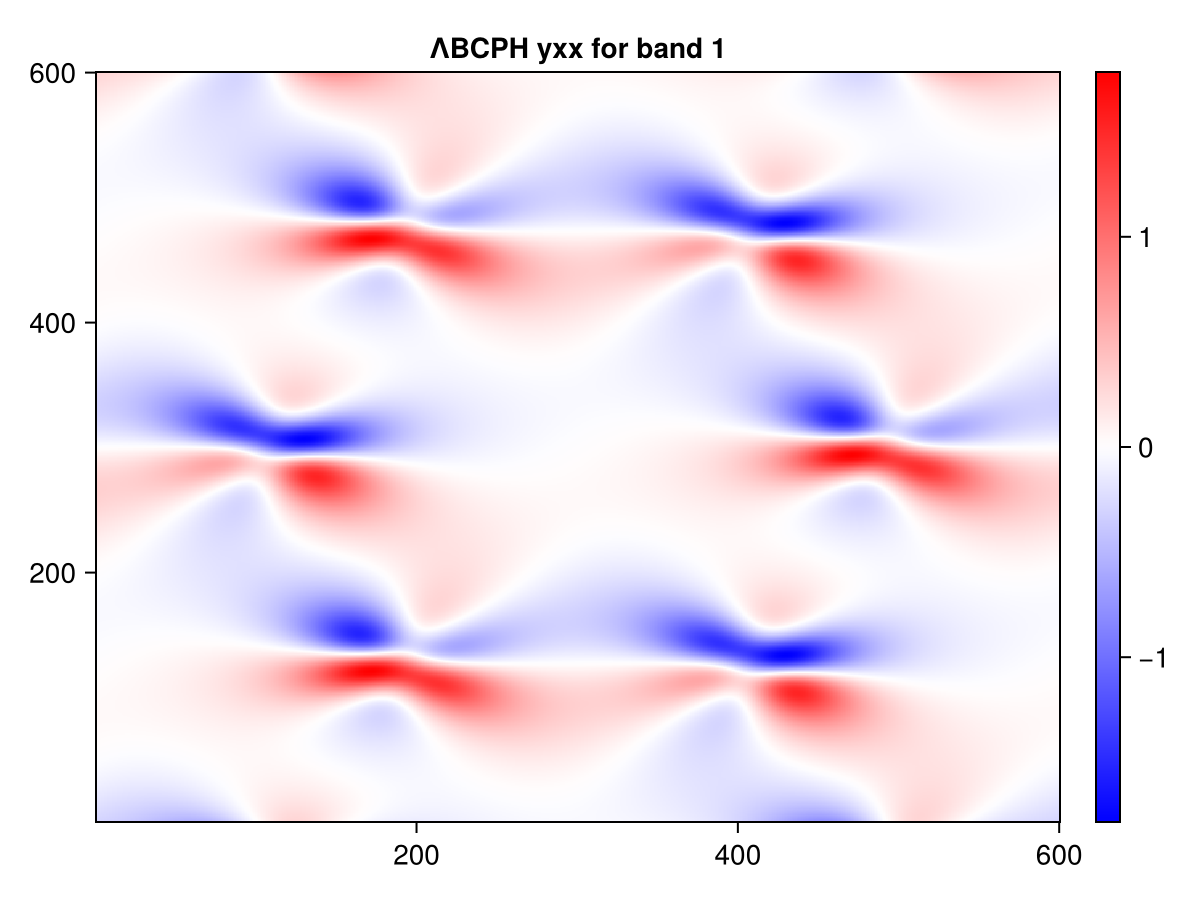

In [19]:
let h = 0.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


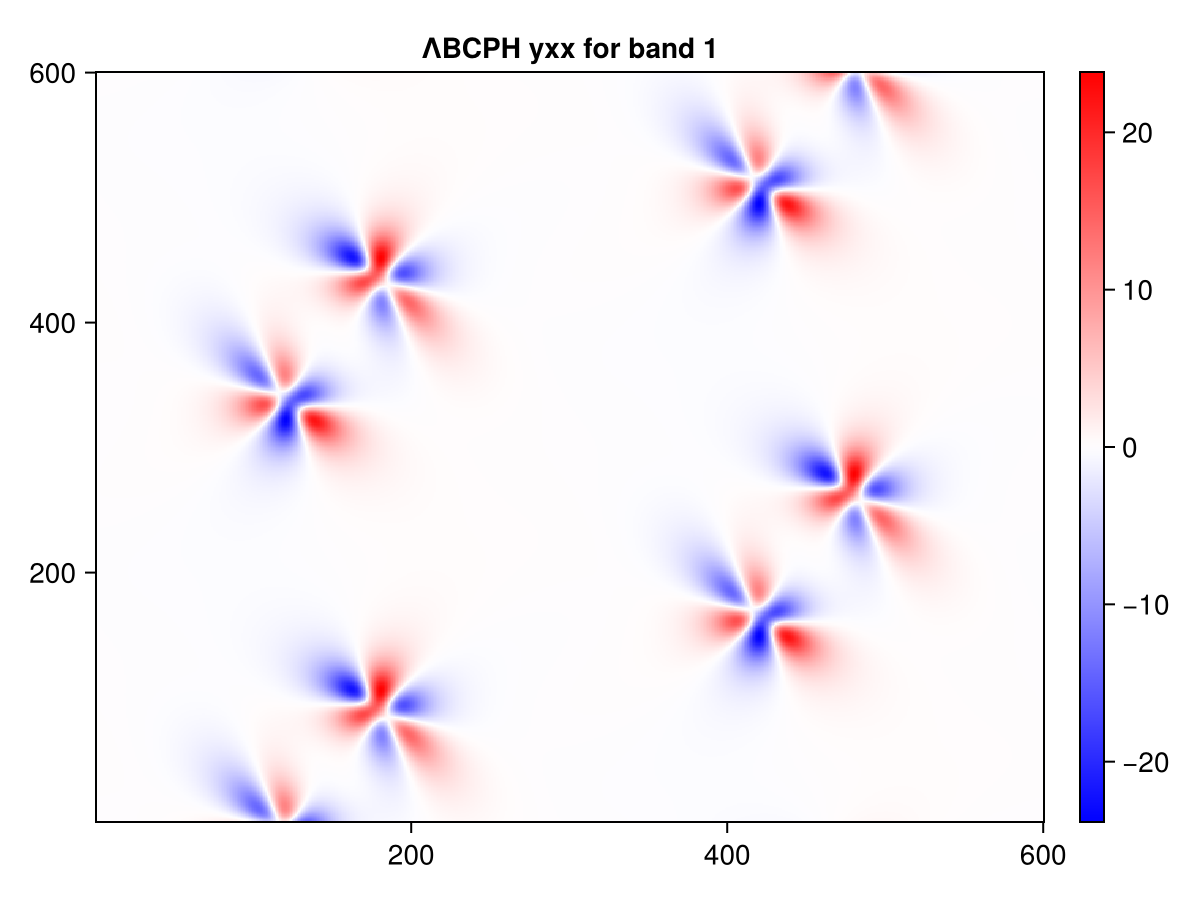

In [20]:
let h = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


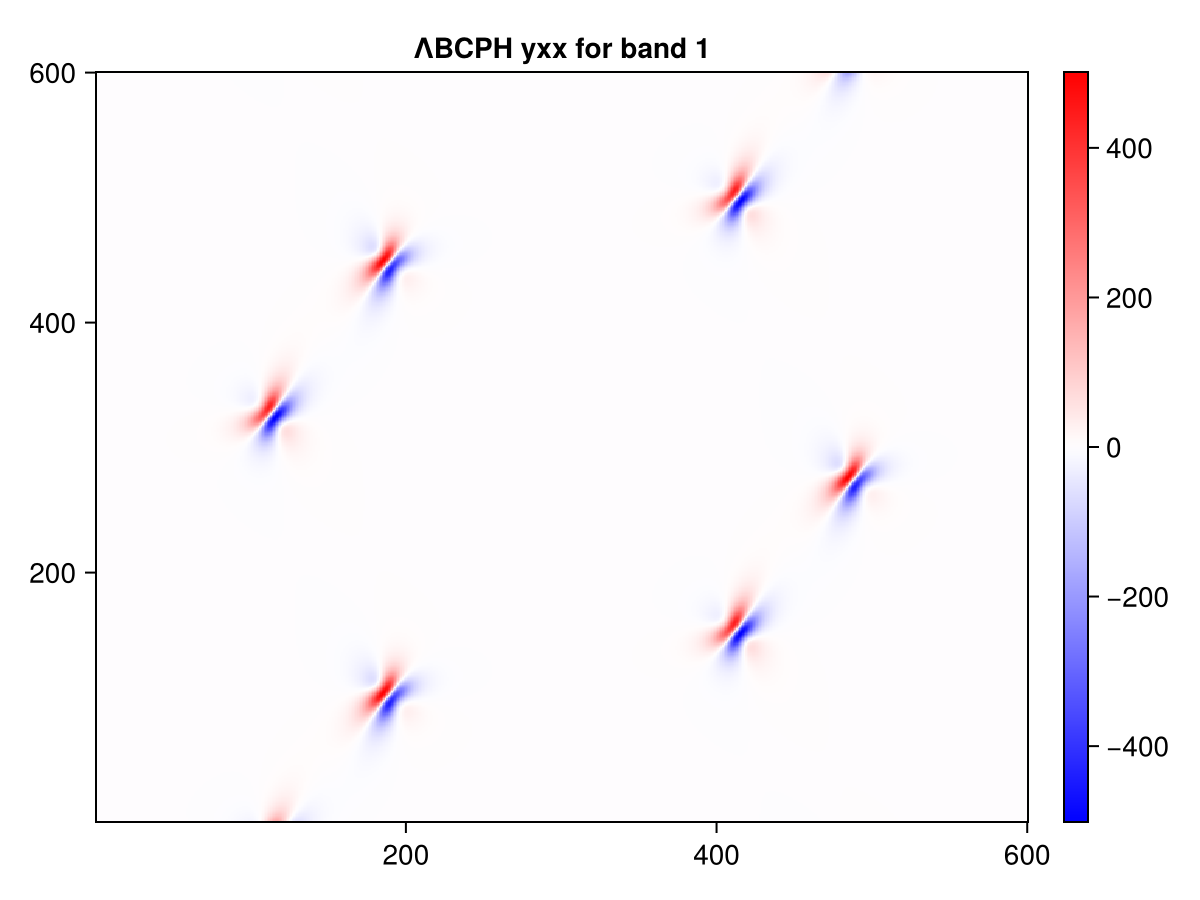

In [21]:
let h = 1.0, t1 = 1.0, t2 = -0.0, u1 = 0.28, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


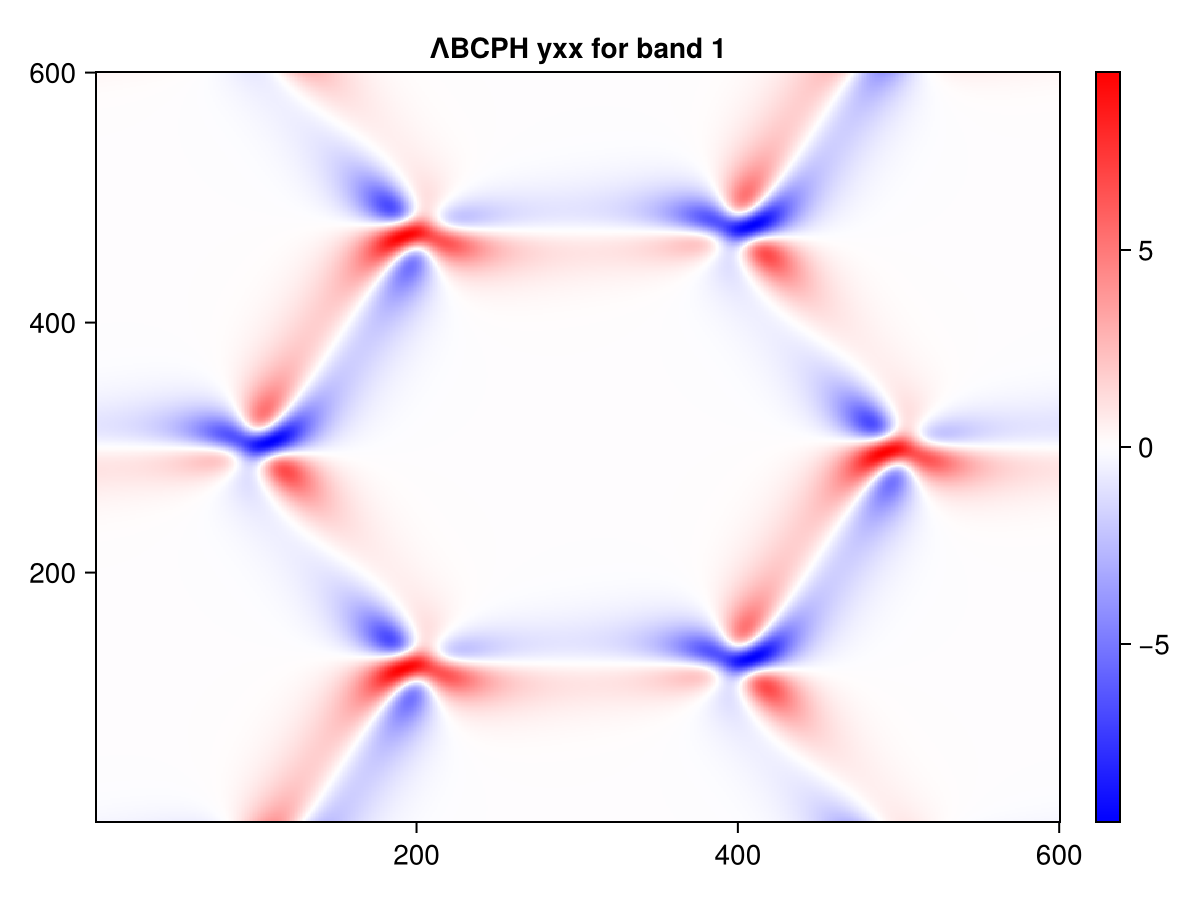

In [22]:
let h = 0.0, t1 = 1.0, t2 = -0.0, u1 = 0.28, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


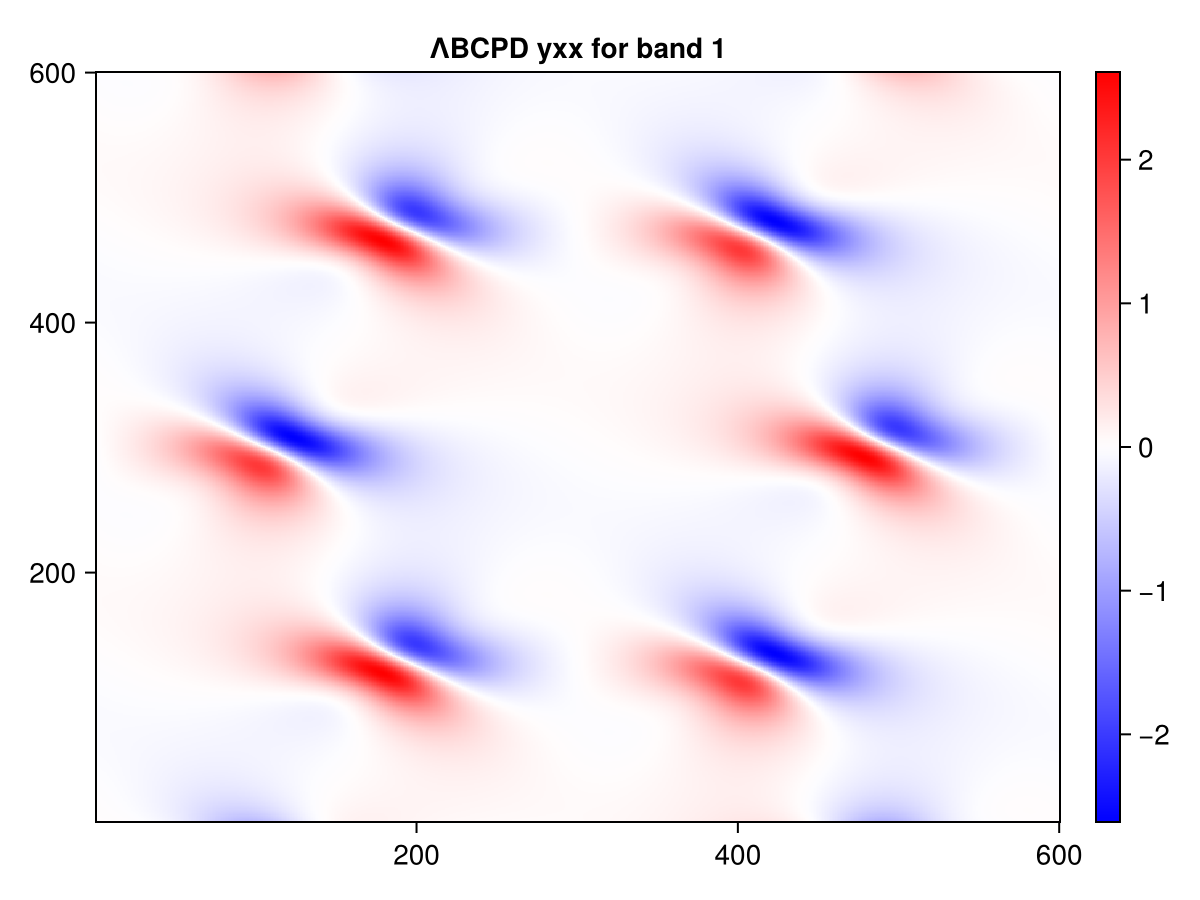

In [23]:
let h = 0.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPD_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


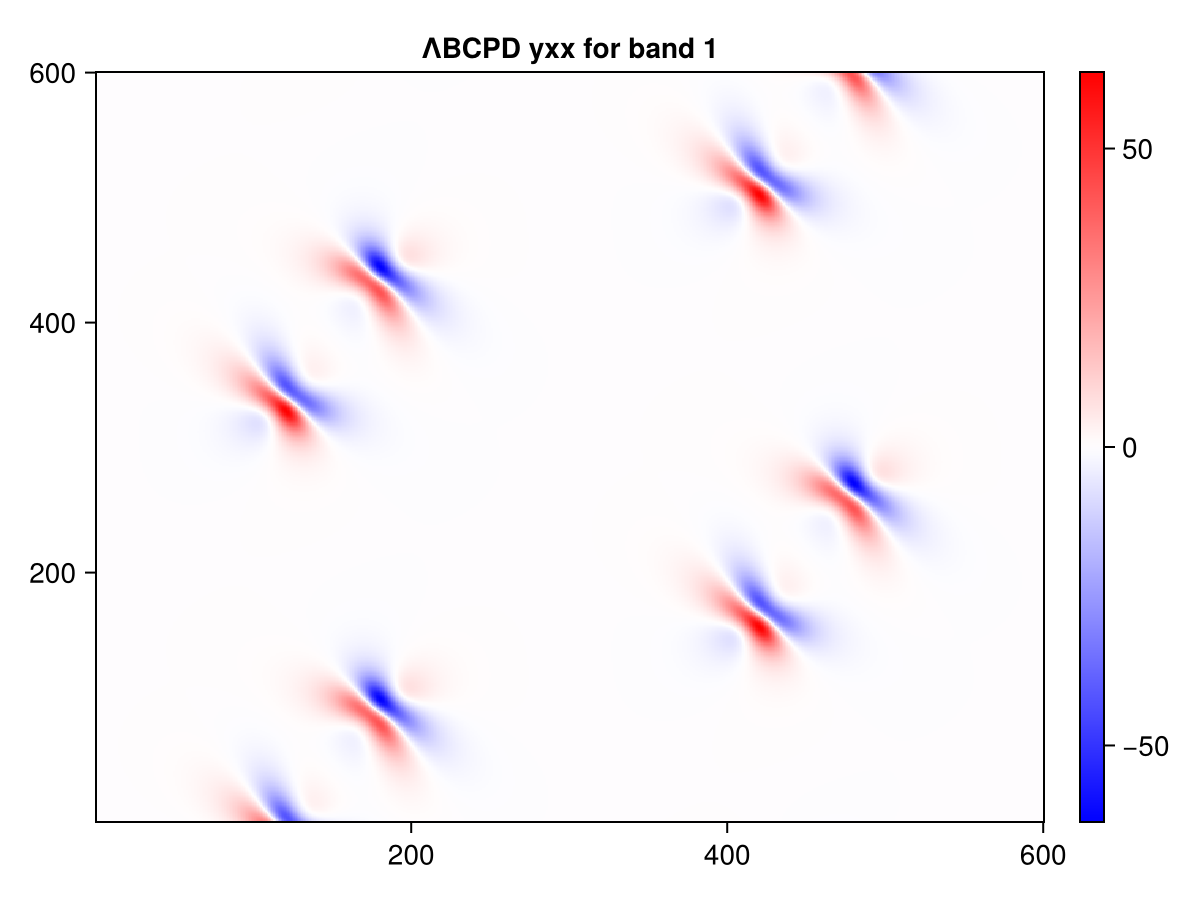

In [24]:
let h = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPD_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


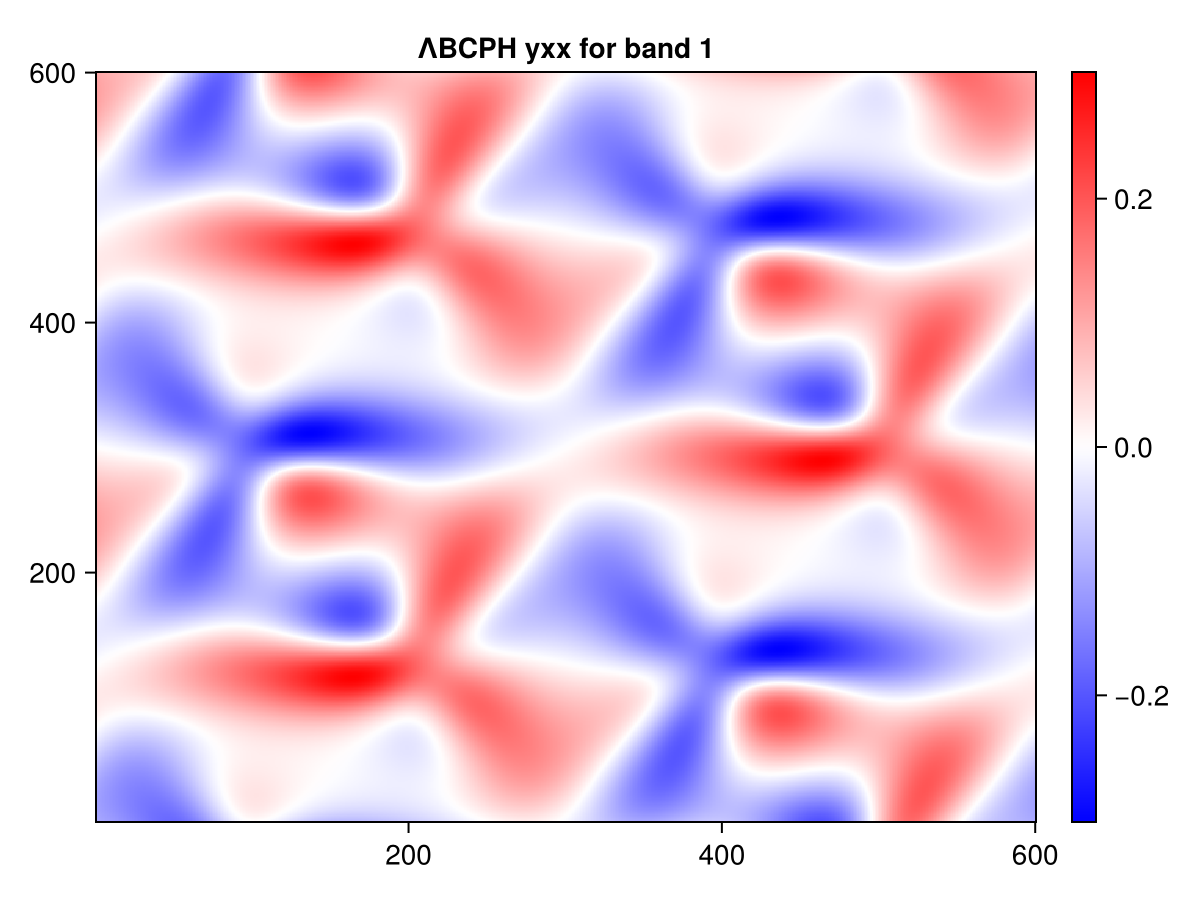

In [25]:
let h = 0.0, t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


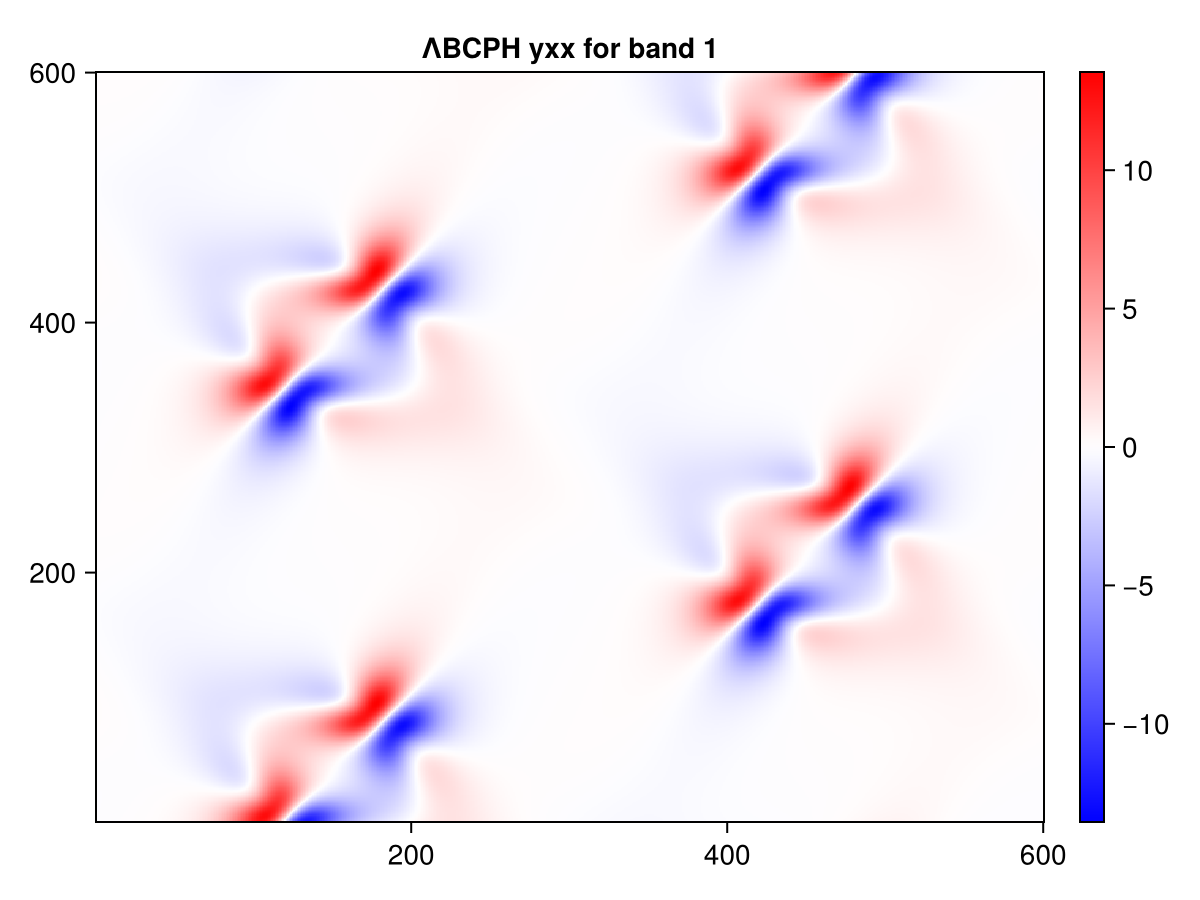

In [26]:
let h = 1.0, t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


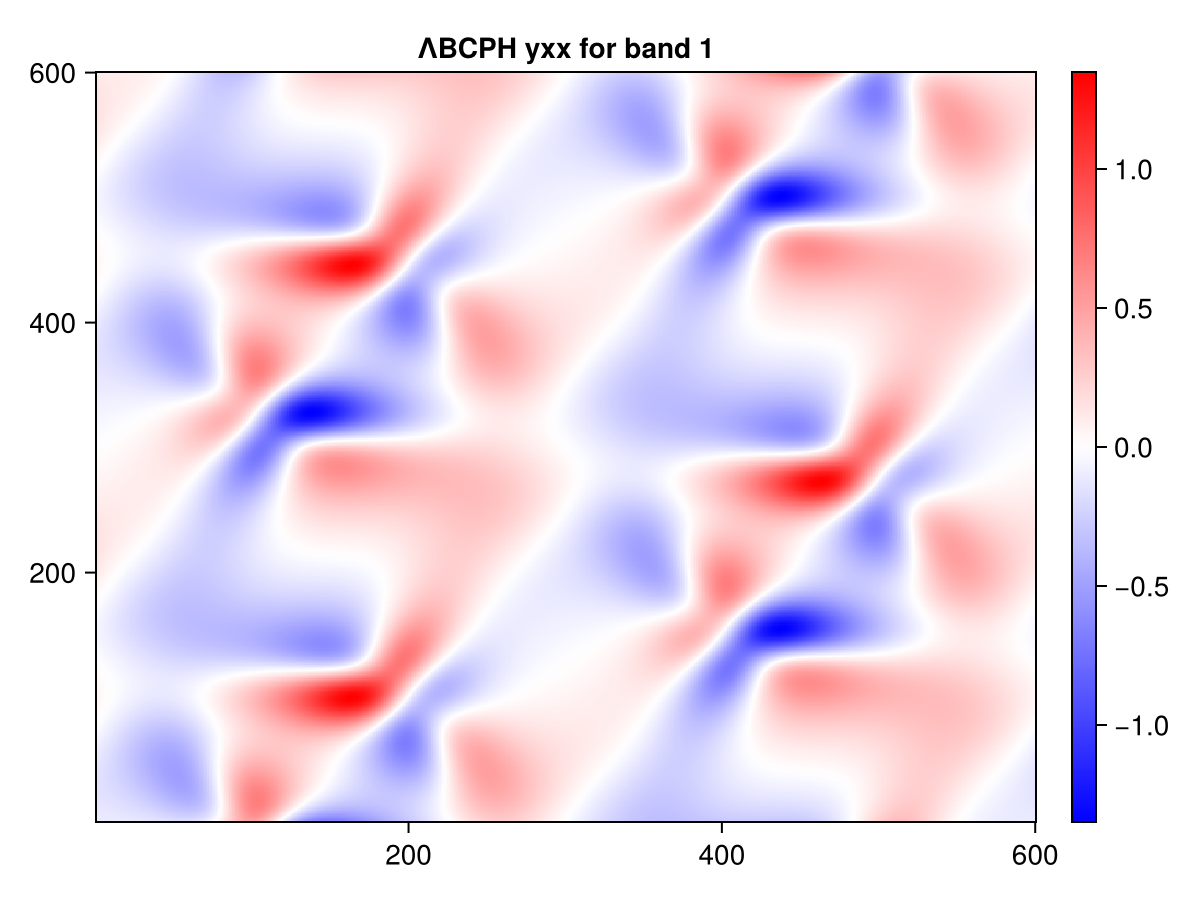

In [27]:
let h = 0.3, t1 = 1.0, t2 = -0.3, u1 = 0.6, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    Plot_Λ_BCPH_fdiff_0Klv(p = p,
        a = 2, b = 1, c = 1, m = m, color_min = -10.0, color_max = 10.0)
end


## Fermi-Dirac Distribution and the Fermi Surface 

In [28]:
## Differential of the Fermi-Dirac Distribution  
@inline function ___dFD_dk(E::Float64, μ::Float64, TKelv::Float64)
    """
    Deprecated 
    Derivatives of the Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    expf::Float64 = exp((11604.518 / TKelv) * (E - μ))
    if isinf(expf)
        return 0.0
    end
    rs = -(11604.518 / TKelv) * expf / (1.0 + expf)^2
    if isnan(rs)
        @info "NaN encountered:  E = $E , μ = $μ  , expf = $expf"
        return 0.0
    end
    rs
end


@inline function dFD_dk(E::Float64, μ::Float64, TKelv::Float64)
    """
    Derivatives of the Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    expf::Float64 = exp((11604.518 / TKelv) * (E - μ))
    if expf > 1e+9
        return 0.0
    end
    -(11604.518 / TKelv) * expf / (1.0 + expf)^2
end


# Fermi-Dirac
@inline function FD(E::Float64, μ::Float64, TKelv::Float64)
    """
    The Fermi-Dirac Function -- Needed to construct Λ_BCPH and Λ_BCPD 
    """
    1.0 / (1.0 + exp((11604.518 / TKelv) * (E - μ)))
end



FD (generic function with 1 method)

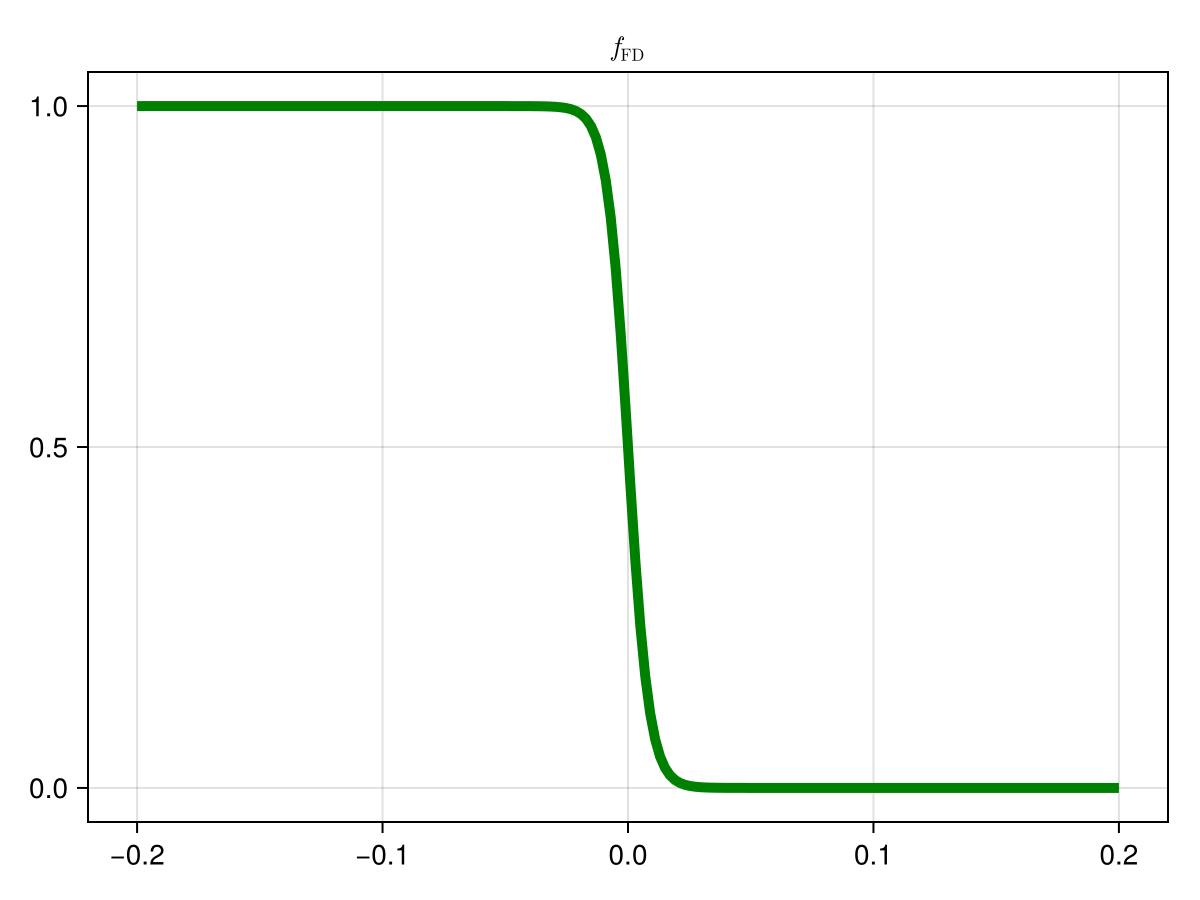

In [30]:
let TKelv = 50.0, μmin = -0.2, μmax = 0.2, μnum = 200
    f = Figure()
    ax = Axis(f[1, 1], title = L"f_{\text{FD}}")
    μvals = LinRange(μmin, μmax, μnum)
    FDvals = FD.(μvals, Ref(0.0), Ref(TKelv))
    l = lines!(ax, μvals, FDvals, linewidth = 5.0, color = :green)
    f
end

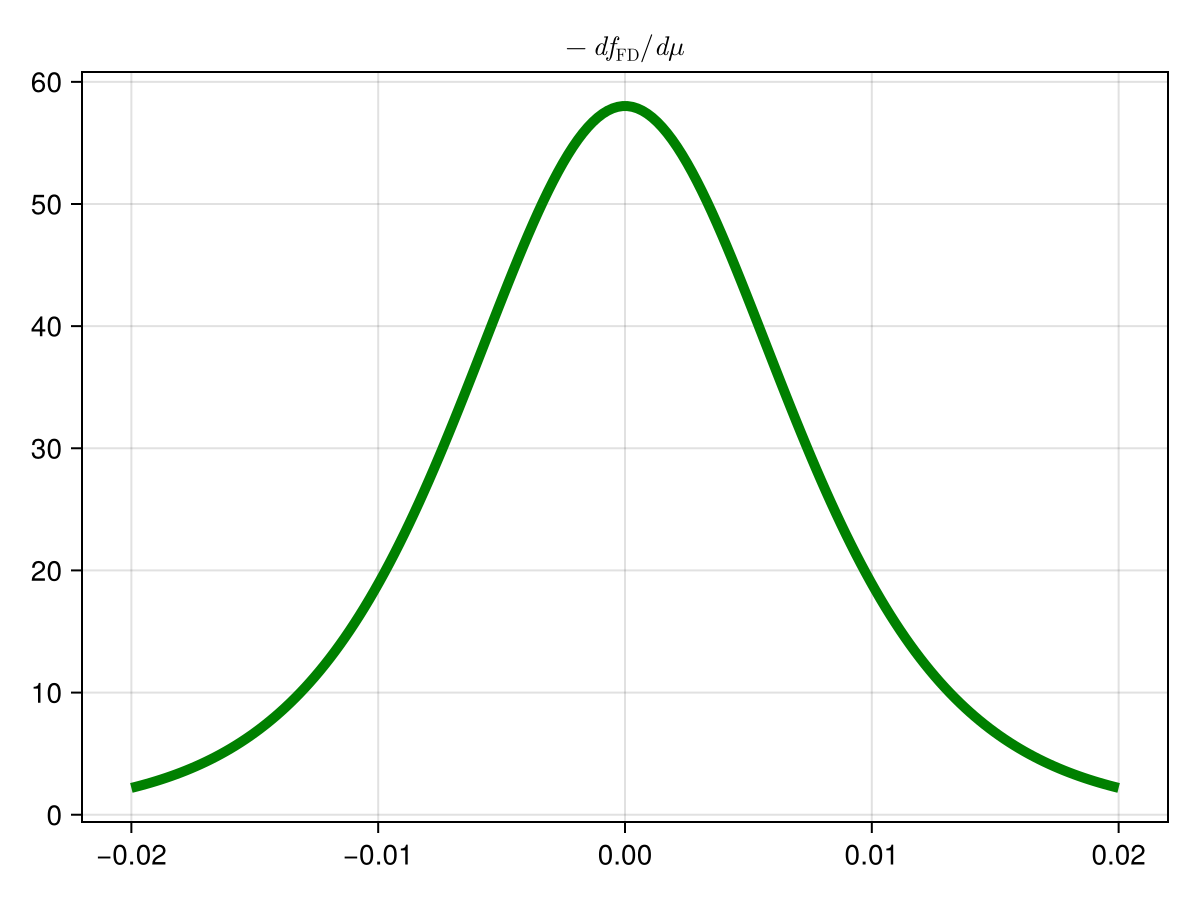

In [31]:
let TKelv = 50.0, μmin = -0.02, μmax = 0.02, μnum = 200
    f = Figure()
    ax = Axis(f[1, 1], title = L"-df_{\text{FD}} / dμ")
    μvals = LinRange(μmin, μmax, μnum)
    FDvals = dFD_dk.(μvals, Ref(0.0), Ref(TKelv))
    l = lines!(ax, μvals, -FDvals, linewidth = 5.0, color = :green)
    f
end

## Nonlinear Transport from BCPH and BCPD 

In [33]:
@inline function BRrenorm_QM(E::Vector{Float64}, Vmn::Vector{Matrix{ComplexF64}},
    a::Int, 
    b::Int
    )
    """
    Band-Renormalized Quantum Metric -- Related to Polarizability.  
    Input: 
        - parameters: νt, Δ
        - a, b: Spatial SO(2) Indices 
    Output: 
        - Gives a matrix in the band basis, here a 2 x 2 matrix connecting the different modes of the Dirac operator 
    """
    ωmn::Matrix{Float64} = E' .- E
    ωmn[ωmn .== 0] .= Inf   # This will kill the diagonal terms 

    Xmn::Vector{Matrix{ComplexF64}} = [-im * Vmn[1] ./ ωmn, -im * Vmn[2] ./ ωmn]

    res = real.(transpose(Xmn)[a] .* Xmn[b] ./ ωmn)
    res
end


@inline function σ_BCPD_integrand(k::Vector{Float64}, E::Vector{Float64}, U::Matrix{ComplexF64}, 
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64})
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    V_orb::Vector{Matrix{ComplexF64}} = V(k, p)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    bc = BRrenorm_QM(E, Vmn, b, c)
    ac = BRrenorm_QM(E, Vmn, a, c)
    ab = BRrenorm_QM(E, Vmn, a, b)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:6
        res += sum(real(Vmn[a][m, m]) * bc[m, :] + real(Vmn[b][m, m]) * ac[m, :] + real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts
end

function σ_BCPD(;p::Params,
    TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int,
    G::Matrix{Float64} = G)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = det(G)
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    
    # First, generate momentum grid 
    rng = LinRange(0.0, 1.0, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, k1) ∈ enumerate(rng)
        for (m, k2) ∈ enumerate(rng)
            grid[n, m] = k1 * G[1, :] + k2 * G[2, :]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U) = eigensystem_kagome(k, p)
        res    += σ_BCPD_integrand(k, E, U, p, a, b, c, TKelv, μvals)
        
    end
    res * dkxdky
end


@inline function σ_BCPH_integrand(k::Vector{Float64}, E::Vector{Float64}, U::Matrix{ComplexF64}, 
    p::Params,
    a::Int, 
    b::Int, 
    c::Int,
    TKelv::Float64,
    μvals::Vector{Float64})
    """
    Berry Curvature Polarizability Hall Components -- Depends on the band index 
    Each Band has a Hall Polarizability and a 'Dissipative' Polarizability 
    """
    V_orb::Vector{Matrix{ComplexF64}} = V(k, p)
    Vmn::Vector{Matrix{ComplexF64}} = [U' * V_orb[1] * U, U' * V_orb[2] * U]

    bc = BRrenorm_QM(E, Vmn, b, c)
    ac = BRrenorm_QM(E, Vmn, a, c)
    ab = BRrenorm_QM(E, Vmn, a, b)
    res::Vector{Float64} = zeros(Float64, size(μvals, 1))
    for m ∈ 1:6
        res += sum(2.0 * real(Vmn[a][m, m]) * bc[m, :] - real(Vmn[b][m, m]) * ac[m, :] - real(Vmn[c][m, m]) * ab[m, :]) * dFD_dk.(Ref(E[m]), μvals, Ref(TKelv))
    end
    -res # minus since this is related to the finite diff method by an integration by parts
end

function σ_BCPH(;p::Params,
    TKelv::Float64,
    a::Int, 
    b::Int,
    c::Int,
    nps::Int,
    μmin::Float64,
    μmax::Float64,
    μnum::Int,
    G::Matrix{Float64} = G)
    """
    This function calculates the BCPH Conductivity as a function of the chemical potential (Fermi surface)
        Note: 
        This function is more computationally demanding.
        There is a three-dimensional integration (2D FBZ x 1D Fermi energies) -> This is discretized to a 3D grid 
        --- Good approach is to use MPI or some other parallelization mechanism e.g. the Distributed Package 
    """
    area::Float64 = det(G)
    nk_tot::Float64 = nps^2
    dkxdky::Float64 = area / nk_tot

    
    # First, generate momentum grid 
    rng = LinRange(0.0, 1.0, nps)
    grid = Matrix{Vector{Float64}}(undef, nps, nps)
    for (n, k1) ∈ enumerate(rng)
        for (m, k2) ∈ enumerate(rng)
            grid[n, m] = k1 * G[1, :] + k2 * G[2, :]
        end # m
    end  # n

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # result: 
    res::Vector{Float64} = zeros(Float64, μnum)

    for k ∈ grid
        (E, U) = eigensystem_kagome(k, p)
        res    += σ_BCPH_integrand(k, E, U, p, a, b, c, TKelv, μvals)
        
    end
    res * dkxdky
end






σ_BCPH (generic function with 1 method)

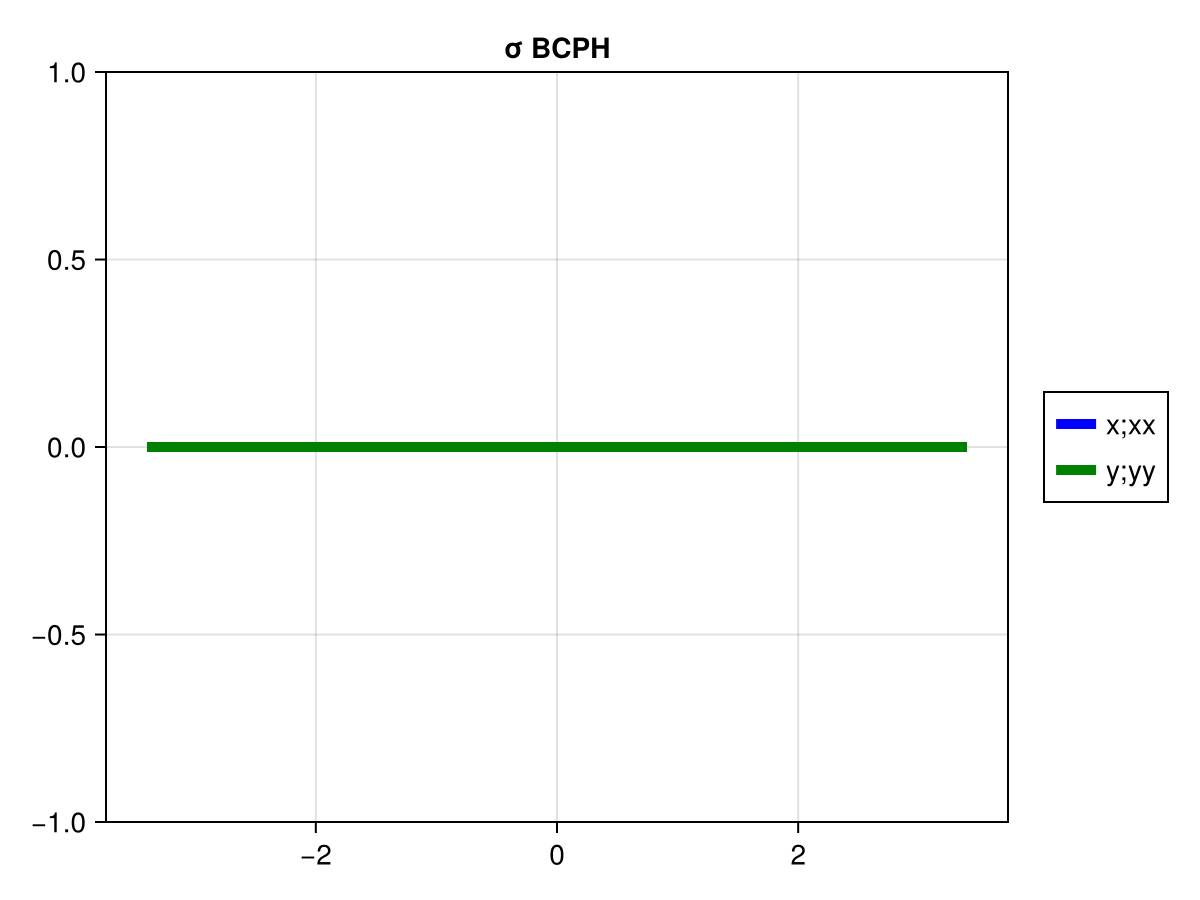

In [34]:
let h = 0.3, t1 = 1.0, t2 = -0.3, u1 = 0.28, u2 = 0.2, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1,
    μmin = -3.4, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(p = p, a = 1, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(p = p, a = 2, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["x;xx", "y;yy"])
    f[1, 2] = legend
    f
end





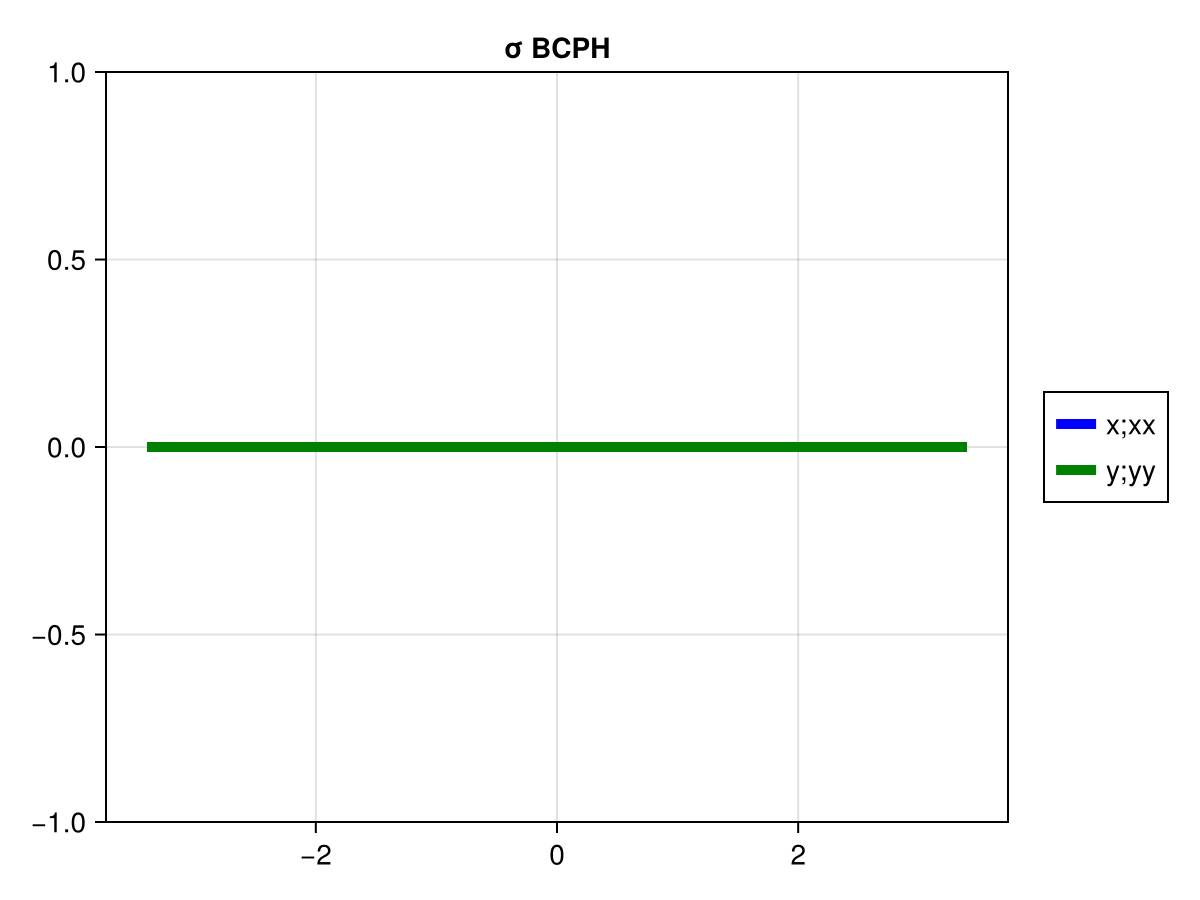

In [35]:
let h = 0.3, t1 = 1.0, t2 = -0.0, u1 = 0.2, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1,
    μmin = -3.4, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(p = p, a = 1, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(p = p, a = 2, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["x;xx", "y;yy"])
    f[1, 2] = legend
    f
end


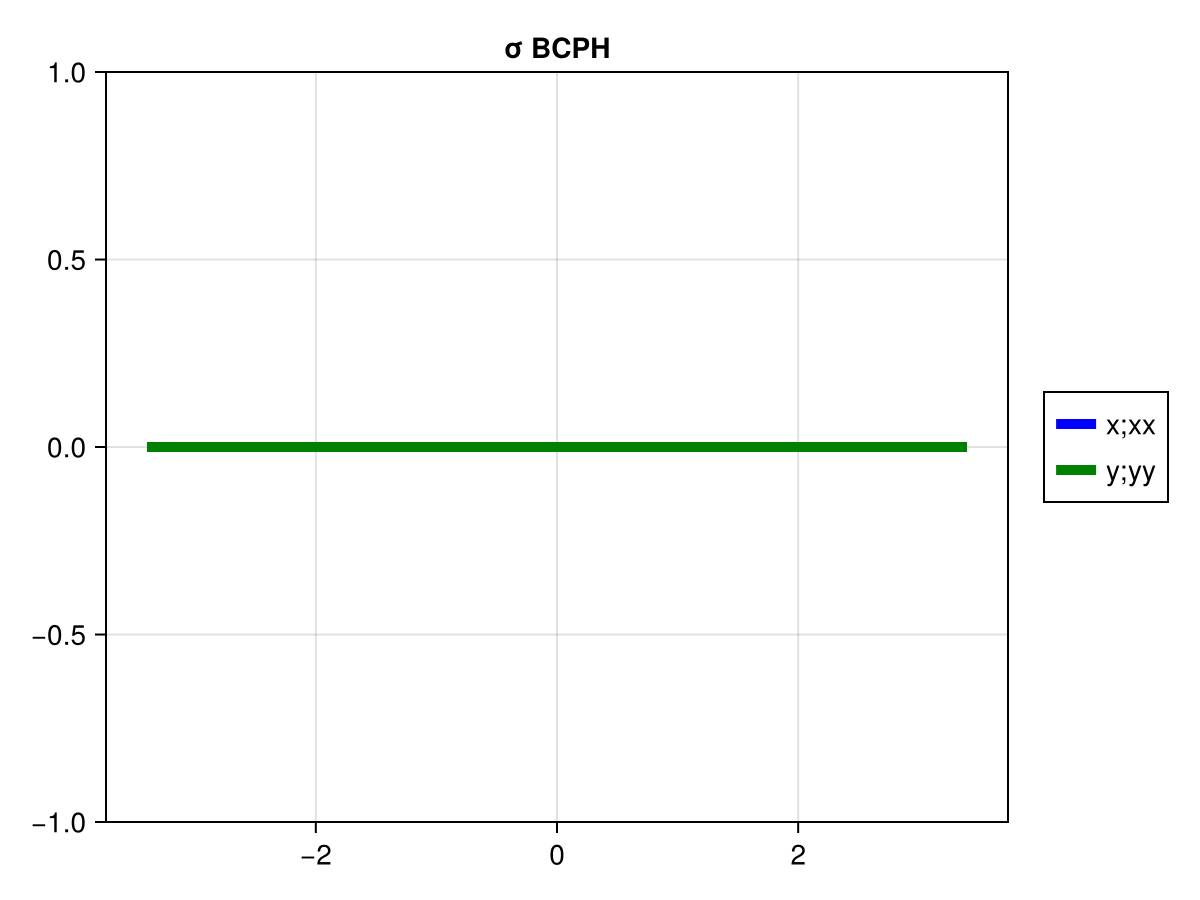

In [38]:
let h = 1.0, t1 = 1.0, t2 = -0.0, u1 = 0.2, u2 = 0.0, B = 0.2, θ = 0.0, ϕ = 0.0, m = 1,
    μmin = -3.4, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(p = p, a = 1, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(p = p, a = 2, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["x;xx", "y;yy"])
    f[1, 2] = legend
    f
end


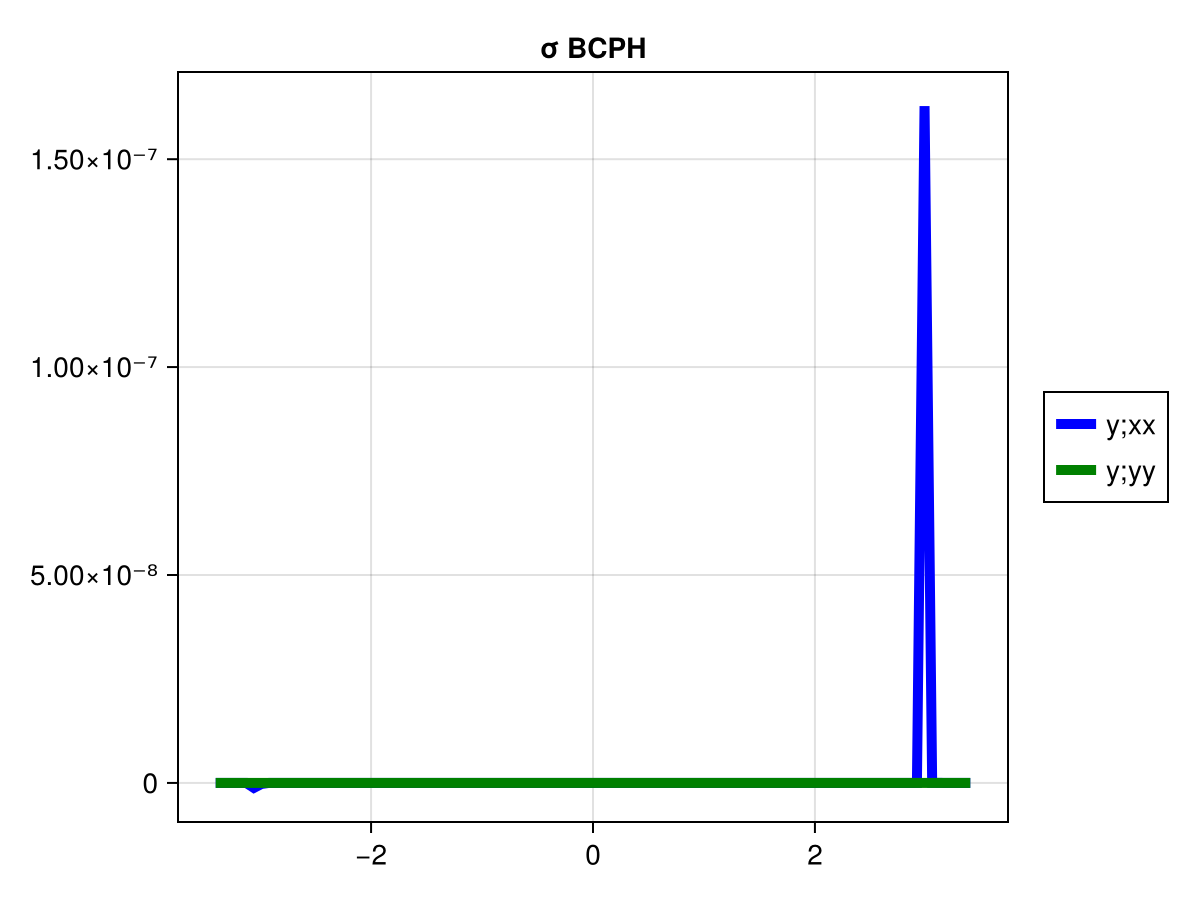

In [40]:
let h = 3.0, t1 = 1.0, t2 = -0.0, u1 = 0.2, u2 = 0.0, B = 0.2, θ = pi / 2.0, ϕ = pi / 2.0, m = 1,
    μmin = -3.4, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(p = p, a = 2, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(p = p, a = 2, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["y;xx", "y;yy"])
    f[1, 2] = legend
    f
end


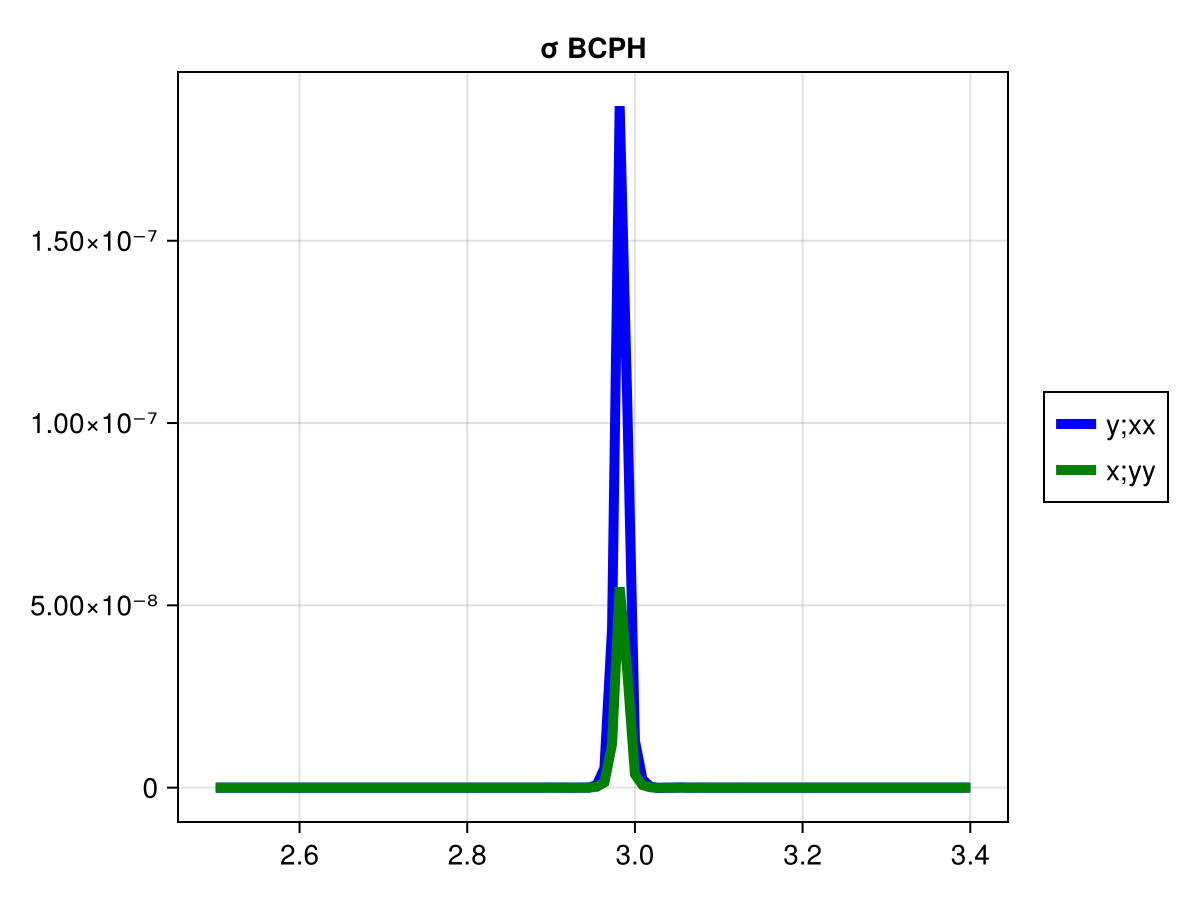

In [43]:
let h = 3.0, t1 = 1.0, t2 = -0.0, u1 = 0.2, u2 = 0.0, B = 0.2, θ = pi / 2.0, ϕ = pi / 2.0, m = 1,
    μmin = 2.5, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPH(p = p, a = 2, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPH(p = p, a = 1, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPH")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["y;xx", "x;yy"])
    f[1, 2] = legend
    f
end


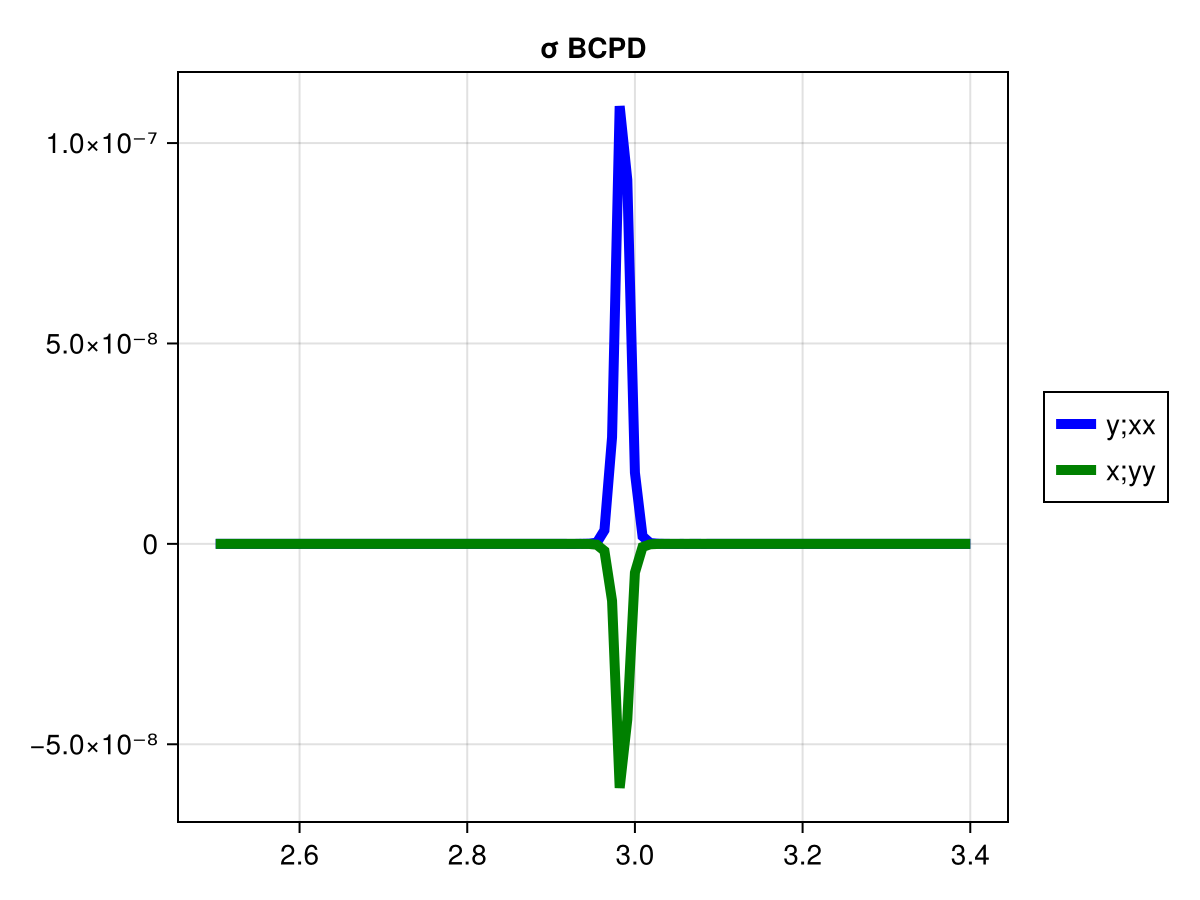

In [48]:
let h = 3.0, t1 = 1.0, t2 = -0.0, u1 = 0.2, u2 = 0.0, B = 0.2, θ = pi / 2.0, ϕ = pi / 2.0, m = 1,
    μmin = 2.5, μmax = 3.4, μnum = 100, nps = 400, TKelv = 50.0

    h1A = h * (-0.5); h2A =  0.5 * h * sqrt(3.0); h3A = 0.0; 
    h1B = h * (-0.5); h2B = -0.5 * h * sqrt(3.0); h3B = 0.0; 
    h1C = h         ; h2C = 0.0                 ; h3C = 0.0;

    p = Params(t1, t2, u1, u2, B, θ, ϕ, h1A, h2A, h3A,
            h1B, h2B, h3B,
            h1C, h2C, h3C)

    # Chemical Potential 
    μvals::Vector{Float64} = LinRange(μmin, μmax, μnum)

    # Main computation 
    res1 = σ_BCPD(p = p, a = 2, b = 1, c = 1, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    res2 = σ_BCPD(p = p, a = 1, b = 2, c = 2, TKelv = TKelv, nps = nps, μmin = μmin, μmax = μmax, μnum = μnum)
    #@info "$res1"
    # Plotting 
    f = Figure()
    ax = Axis(f[1, 1], title = "σ BCPD")
    m1 = lines!(ax, μvals, res1, linewidth = 5.0, color = :blue)
    m2 = lines!(ax, μvals, res2, linewidth = 5.0, color = :green)
    legend = Legend(f, [m1, m2], ["y;xx", "x;yy"])
    f[1, 2] = legend
    f
end


### Testing C_3 Symmetry 


In [ ]:
function test_C_3(; t1::Float64, 
    t2::Float64, 
    u1::Float64, 
    u2::Float64, 
    B::Float64, 
    θ::Float64, 
    ϕ::Float64, 
    tol::Float64 = 1e-6, 
    npts = 100)
    
end
